# Background

Pauli-twirling is a quantum error suppression technique that uses randomization to noise shape coherent error into stochastic errors, by combining the results from many random, but logically equivalent circuits, together. This is beneficial because while incoherent errors add up linearly with circuit depth, coherent errors can scale quadratically. Here we will show how to generate Pauli-twirled circuits, where we focus on twirling two-qubit gates within a circuit. This technique has been used, for example, in this work by Kim et al.: arXiv:2108.09197. We will show how to compute the possible Pauli sets for any two-qubit gate, and show how to create a Qiskit `Passmanager` that implements the routine, and can be combined with other transpilation techniques.

![benefit_of_twirling.png](imgs/benefit_of_twirling.png)  
Credits: Zlatko Minev, IBM Quantum (https://www.zlatko-minev.com/blog/twirling)

In [1]:
import numpy as np
from itertools import product

from qiskit import *
# Need gate classes for generating the Pauli twirling sets
from qiskit.circuit.library import (IGate, XGate, YGate, ZGate,
                                    CXGate, CZGate, ECRGate, iSwapGate)

from qiskit.quantum_info import Operator
# Classes for building up a directed-acyclic graph (DAG) structure
from qiskit.circuit import QuantumRegister
from qiskit.dagcircuit import DAGCircuit
# Transpiler stuff neded to make a pass and passmanager
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passes import Optimize1qGatesDecomposition

# A fake system to transpile against
from qiskit.providers.fake_provider import FakeHanoiV2, FakeMumbai
from qiskit.quantum_info import SparsePauliOp

# Setup: test circuit and backend

In [2]:
# Create Circuit
def create_ghz_circuit(num_qubits):
    ghz_circuit = QuantumCircuit(num_qubits, num_qubits)
    ghz_circuit.h(0)
    for qubit in range(1, num_qubits):
        ghz_circuit.cx(0, qubit)

    ghz_circuit.barrier()
    ghz_circuit.measure(range(num_qubits), range(num_qubits))
    
    return ghz_circuit

In [3]:
num_qubits = 3
circuit = create_ghz_circuit(num_qubits=num_qubits)
operator = SparsePauliOp("Z"*num_qubits)

In [4]:
backend = FakeHanoiV2()
transpiled_circuit = transpile(circuit, backend=backend, optimization_level=3)

/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


# PT Circuit transformation

![twirling_2q_gates.svg](imgs/twirling_2q_gates.svg)

## Computing Pauli twirling gate sets

As the name suggests, we are going to look at using single qubit Pauli operators to reshape the noise in our circuits. Because the bulk of the error in a circuit resides with the two-qubit gates, here we focus on Pauli twirling two-qubit gates only.

We are looking for sets of 4 Pauli gates that when pre-pended and appended to a circuit containing a two-qubit gate, the unitary is equal to that of the single two-qubit gate alone. This makes sense of course, as otherwise our circuit would not do what we want it to. We now need to figure out which combinations of Pauli gates satisfies this requirement. IBM Quantum systems have 3 different two-qubit entangling gates: CNOT, CZ, and ECR, and the corresponding Pauli combinations are obviously going to depend on which gate we are looking at. Now for common gates like CNOT, one can find tables of Paulis in the literature. However, for a gate like ECR, I am not sure such a table exists. We could compute these by hand, but here we are going to be smarter and let the computer do all the work for us.

First, let us generate some instances of the Pauli gates, as well as a collection of 2Q gates:

In [5]:
# Single qubit Pauli gates
I = IGate()
Z = ZGate()
X = XGate()
Y = YGate()

# 2Q entangling gates
CX = CXGate()
CZ = CZGate()
ECR = ECRGate()

Now let us put the computer to work finding all possible combinations of Paulis that leave the action of a two-qubit gate unchanged, up to a phase factor. Below we create a function that takes a Qiskit two-qubit gate as the input, and finds all the Pauli combinations by treating it as a 16 choose 4 problem, and letting Python generate all the possibilities. If the unitary remains unchanged, then we add the combination of Paulis to the output list, along with a phase value of Zero. However, if the unitaries differ by a phase factor of $\pi$, we add a global phase of $\pi$ 

In [6]:
def generate_pauli_twirling_sets(two_qubit_gate):
    """Generate the Pauli twirling sets for a given 2Q gate
    
    Sets are ordered such that gate[0] and gate[1] are pre-roations
    applied to control and target, respectively.  gate[2] and gate[3]
    are post-rotations for control and target, respectively.
    
    Parameters:
        two_qubit_gate (Gate): Input two-qubit gate
        
    Returns:
        list: List of all twirling gate sets
    """
    pauli_gates_list = [I, Z, X, Y]
    # This is the target unitary to which our twirled circuit should match
    target_unitary = Operator(two_qubit_gate.to_matrix())
    twirling_sets = []
    
    # For every combination in 16 choose 4 make a circuit and look for equivilence
    for gates in product(pauli_gates_list, repeat=4):
        # Build a circuit for our twirled 2Q gate
        qc = QuantumCircuit(2)
        qc.append(gates[0], [0])
        qc.append(gates[1], [1])
        qc.append(two_qubit_gate, [0, 1])
        qc.append(gates[2], [0])
        qc.append(gates[3], [1])
        
        norm = np.linalg.norm(Operator.from_circuit(qc)-target_unitary)
        
        phase = None
        # If unitaries match we have a phase of zero
        if abs(norm) < 1e-15:
            phase = 0
        # If unitaries differ by a phase of pi, shift by pi
        elif abs(norm-4) < 1e-15:
            phase = np.pi

        if phase is not None:
            qc.global_phase += phase
            # Verify that our twirled circuit is a valid replacement
            assert Operator.from_circuit(qc) == target_unitary
            twirl_set = (gates, phase)
            # Check that set does not already exist
            if twirl_set not in twirling_sets:
                twirling_sets.append(twirl_set)
            
    return twirling_sets

With this function in hand, we are now in a position to generate the Pauli twirling sets for any two-qubit gate that Qiskit understands. Here we generate the sets for each of the two-qubit gate instances above. In preparation for using them later, we store the sets in a dictionary with the gate name as the key. In practice you should do this once, and then cache / hard-code the results for fast retrieval.

In [7]:
twirling_groups = {} 

for gate in [CX, CZ, ECR]:
    twirl_set = generate_pauli_twirling_sets(gate)
    twirling_groups[gate.name] = twirl_set

For example, here is the set for the CNOT (CX) gate. We see that two of the twirling sets have a non-zero phase factor.

In [8]:
twirling_groups['cx']

[((Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='id', num_qubits=1, num_clbits=0, params=[])),
  0),
 ((Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='z', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='z', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='z', num_qubits=1, num_clbits=0, params=[])),
  0),
 ((Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='x', num_qubits=1, num_clbits=0, params=[])),
  0),
 ((Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='y', num_qubits=1, num_clbits=0, params=[]),
   Instruction(name='z', num_qubits=1, num_clbits=0, params=[

### Twirling Qiskit circuits

With our twirling sets in hand, we are now in a position to apply Pauli twirling to a given circuit. Pauli twirling is a circuit transformation and thus is best utilized as a transpilation pass. Below is a pass called `PauliTwirling` that performs twirling on a specific two-qubit gate, and utilizes the dictionary of twirling sets that we generated above.

In [9]:
class PauliTwirling(TransformationPass):
    """Pauli twirl an input circuit.
    """
    def __init__(self, twirling_gate, seed=None):
        """
        Parameters:
            twirling_gate (str): Which gate to twirl
            seed (int): Seed for RNG, should be < 2e32
        """
        super().__init__()
        # This is the target gate to twirl
        self.twirling_gate = twirling_gate
        # Get the twirling set from the dict we generated above
        # This should be repalced by a cached version in practice
        self.twirling_set = twirling_groups[twirling_gate]
        # Length of the twirling set to bound RNG generation
        self.twirling_len = len(self.twirling_set)
        # Seed the NumPy RNG
        self.rng = np.random.default_rng(seed)

    def run(self, dag):
        """Insert Pauli twirls into input DAG
        
        Parameters:
            dag (DAGCircuit): Input DAG
        
        Returns:
            dag: DAG with twirls added in-place
        """
        for run in dag.collect_runs([self.twirling_gate]):
            for node in run:
                # Generate a random int to specify the twirling gates
                twirl_idx = self.rng.integers(0, self.twirling_len)
                # Get the randomly selected twirling set
                twirl_gates = self.twirling_set[twirl_idx][0]
                twirl_phase = self.twirling_set[twirl_idx][1]
                # Make a small DAG for the twirled circuit we are going to insert
                twirl_dag = DAGCircuit()
                # Add a register of qubits (here always 2Q)
                qreg = QuantumRegister(2)
                twirl_dag.add_qreg(qreg)
                # gate[0] pre-applied to control
                twirl_dag.apply_operation_back(twirl_gates[0], [qreg[0]])
                # gate[1] pre-applied to target
                twirl_dag.apply_operation_back(twirl_gates[1], [qreg[1]])
                # Insert original gate
                twirl_dag.apply_operation_back(node.op, [qreg[0], qreg[1]])
                # gate[2] pre-applied to control
                twirl_dag.apply_operation_back(twirl_gates[2], [qreg[0]])
                # gate[3] pre-applied to target
                twirl_dag.apply_operation_back(twirl_gates[3], [qreg[1]])
                # Add a global phase gate to account for possible phase difference
                twirl_dag.global_phase += twirl_phase
                # Replace the target gate with the twirled version
                dag.substitute_node_with_dag(node, twirl_dag)
        return dag

In [10]:
pm = PassManager([PauliTwirling('cx', seed=54321)])

We suggest always twirl a *transpiled* circuit as an input circuit is written using most convenient gates, e.g., 3+ qubit gates, non-basis gates, etc. When the gates do not match the two-qubit basis gate of the system, we need to transpile first, and then twirl.

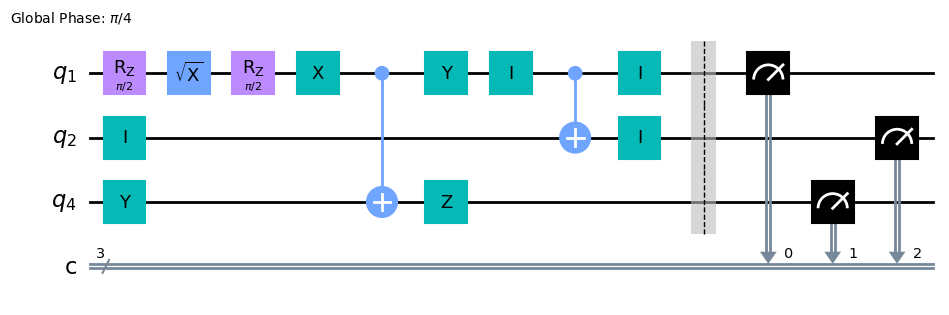

In [11]:
twirl_qc = pm.run(transpiled_circuit)
twirl_qc.draw('mpl', idle_wires=False)

The twirled circuit can be further optimized in terms of single qubit gates. As such, we construct as new Passmanager that does the Pauli twirling, and then performs single-qubit gate optimization.

In [12]:
post_pm = PassManager([PauliTwirling('cx', seed=54321), 
                       Optimize1qGatesDecomposition(backend.target.operation_names)])

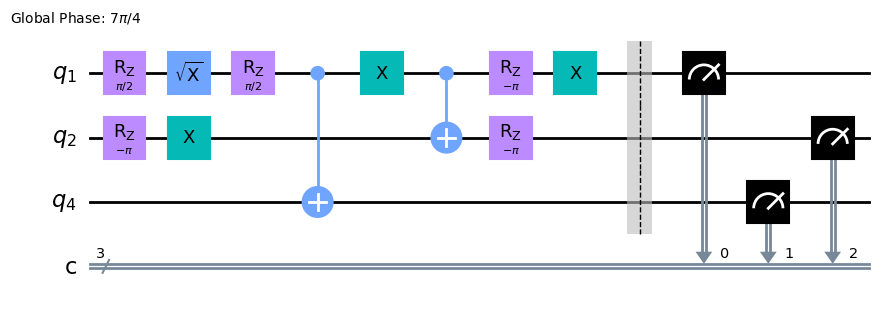

In [13]:
post_twirl_qc = post_pm.run(transpiled_circuit)
post_twirl_qc.draw('mpl', idle_wires=False)

In [14]:
num_twirls = 3
twirl_qc_list = [post_pm.run(transpiled_circuit) for _ in range(num_twirls)]

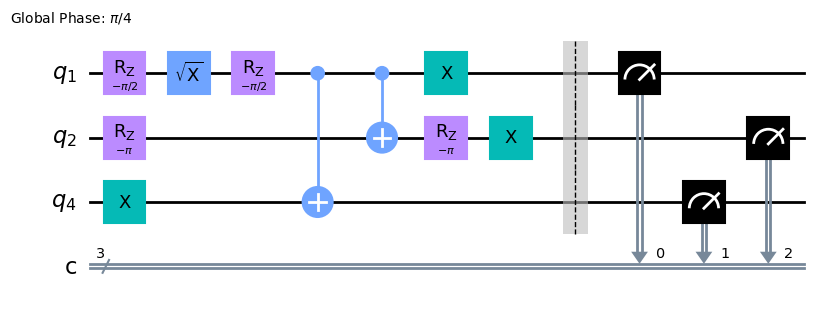

In [15]:
twirl_qc_list[0].draw("mpl", idle_wires=False)

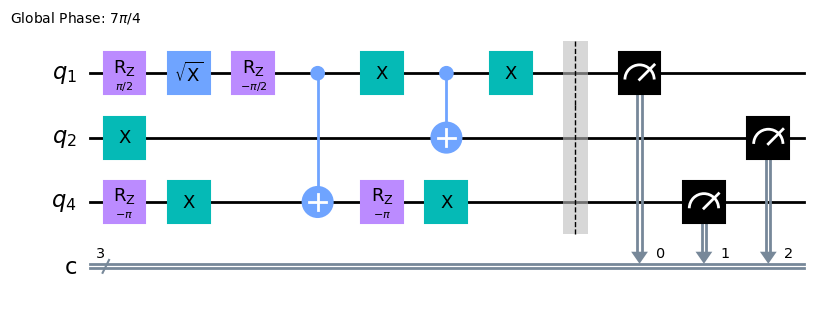

In [16]:
twirl_qc_list[1].draw("mpl", idle_wires=False)

## Execution

When twirling, the number of shots per circuit is usually reduced. That is to say that, if before you ran one circuit 10000 times, then you can try executing 10 twirled circuits with 1000 shots each, or 100 circuits at 100 shots, etc. Keep in mind that the IBM Quantum infrastructure is optimized for many shots per circuit, and therefore it will take longer to run more circuits at fewer shots. But, if you want to try to improve your results, it might be a trade-off worth making.

In [17]:
shots_per_twirl = 10000 // len(twirl_qc_list)
counts = backend.run(twirl_qc_list, shots=shots_per_twirl).result().get_counts()

## Result Post-processing

Post-processing for Pauli Twirling involves *aggregating* the results. It can be aggregating the `Counts` dictionaries or averaging the probability distribution across many twirls.

In [18]:
def aggregate_data(data, normalize=False):
    """Function to aggregate data from many twirls.
    When `normalize=False`, it adds `values` per `key` across all twirls.
    When `normalize=True`, it averages `values` per `key` across all twirls.
    For (quasi) probability distributions, we should normalize (average) the aggregated probabilities.
    
    Example-1: Consider `Counts` for 3 twirls: {'0': 400, '1': 600}, {'0': 500, '1': 500}, {'0': 600, '1': 400}.
    After aggregation (with `normalize=False`), it will return a single aggregated dictionary {'0': 1500, '1': 1500}.
    
    Example-2: Consider quasi distribution for 3 twirls: {'0': 0.4, '1': 0.6}, {'0': 0.5, '1': 0.5}, {'0': 0.6, '1': 0.4}.
    After aggregation (with `normalize=True`), it will return a single aggregated dictionary
    {'0': (0.4+0.5+0.6)/3, '1': (0.6+0.5+0.4)/3} = {'0': 0.5, '1': 0.5}.
    """
    aggregated = {}

    total = len(data) if normalize else 1
    
    for dist in data:
        for key in dist:
            aggregated[key] = aggregated.get(key, 0) + (dist[key]/total)
            
    return aggregated

In [19]:
counts_agg = aggregate_data(data=counts, normalize=False)

In [20]:
for i in range(len(twirl_qc_list)):
    print(f"Counts twirl-{i}: {counts[i]}")

Counts twirl-0: {'101': 18, '000': 1614, '010': 13, '001': 20, '100': 30, '110': 19, '011': 21, '111': 1598}
Counts twirl-1: {'110': 24, '001': 19, '100': 30, '011': 27, '111': 1551, '010': 20, '000': 1644, '101': 18}
Counts twirl-2: {'101': 23, '100': 31, '110': 9, '001': 15, '111': 1609, '011': 18, '010': 14, '000': 1614}


In [21]:
print(f"aggregated counts {counts_agg}")

aggregated counts {'101': 59.0, '000': 4872.0, '010': 47.0, '001': 54.0, '100': 91.0, '110': 52.0, '011': 66.0, '111': 4758.0}


In [22]:
import numpy
print(f"numpy version {numpy.__version__}")

import qiskit_ibm_runtime
print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")

import qiskit.tools.jupyter
%qiskit_version_table

numpy version 1.23.5
qiskit runtime version 0.13.0
